In [1]:
import tensorflow as tf
import tools.datasets.mnist3 as mnist_tools
import tools.datasets.svhn as svhn_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch
from functools import partial

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
mnist_train_images, mnist_train_labels = mnist_tools.get_data('train')
mnist_test_images, mnist_test_labels = mnist_tools.get_data('test')
svhn_train_images, svhn_train_labels = svhn_tools.get_data('train')
svhn_test_images, svhn_test_labels = svhn_tools.get_data('test')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# labeled samples used per class
# sup_per_class = 10
sup_per_class = 1280
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 64 
# unlabeled samples per batch
unsup_batch_size = 1024
unsup_samples = 10240

learning_rate = 1e-4
decay_steps = 9000
decay_factor = 0.33
logit_weight = 1.0

max_steps = 2000
eval_interval = 500

log_dir = "logs/training/mnist-svhn/mnist-svhn"

seed = 1

IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE
NUM_LABELS = mnist_tools.NUM_LABELS

# [10 (classes), 10 (samples), 28, 28, 1]
sup_by_label = semisup.sample_by_label(mnist_train_images, mnist_train_labels,
                        sup_per_class, NUM_LABELS, seed)

In [5]:
visit_weight_evelope = "linear"
visit_weight = 0.8
visit_weight_envelope_steps = 1
visit_weight_envelope_delay = 500

walker_weight_evelope = "linear"
walker_weight = 0.8
walker_weight_envelope_steps = 1
walker_weight_envelope_delay = 500

TARGET_SHAPE = svhn_tools.IMAGE_SHAPE
TEST_SHAPE   = TARGET_SHAPE

image_shape = IMAGE_SHAPE
new_shape   = TARGET_SHAPE
emb_size    = 128

In [6]:
# Sample unlabeled training subset.
if unsup_samples > -1:
    num_unlabeled = len(svhn_train_images)
    assert unsup_samples <= num_unlabeled, (
        'Chose more unlabeled samples ({})'
        ' than there are in the '
        'unlabeled batch ({}).'.format(unsup_samples, num_unlabeled))

    rng = np.random.RandomState(seed=seed)
    choice = rng.choice(num_unlabeled, unsup_samples, False)
    sampled_unsup_images = svhn_train_images[choice]
    sampled_unsup_labels = svhn_train_labels[choice]
else:
    sampled_unsup_images = svhn_train_images
    sampled_unsup_labels = svhn_train_labels

In [7]:
from ipywidgets import IntProgress, Layout
from train import apply_envelope

graph = tf.Graph()

with graph.as_default():
    
    unsup_data = up.create_input(sampled_unsup_images, sampled_unsup_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    sup_data,sup_label = up.create_per_class_inputs_v2(sup_by_label, sup_per_batch)
    sup_it             = sup_data.repeat().make_one_shot_iterator()
    sup_it_label       = sup_label.repeat().make_one_shot_iterator()
    
    model_func = partial(
        arch.svhn_model,
        new_shape=new_shape,
        img_shape=image_shape,
        emb_size=emb_size
    )
    
    model = semisup.SemisupModel(model_func, NUM_LABELS, IMAGE_SHAPE,
                                 test_in=tf.placeholder(np.float32, [None] + TEST_SHAPE, 'test_in')
                                )
    
    t_sup_images, t_sup_labels = tf.concat( sup_it.get_next(), 0), tf.concat( sup_it_label.get_next(), 0)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    visit_weight = apply_envelope(
        type = visit_weight_evelope,
        step = model.step,
        final_weight = visit_weight,
        growing_steps = visit_weight_envelope_steps,
        delay = visit_weight_envelope_delay
    )
    
    walker_weight = apply_envelope(
        type = walker_weight_evelope,
        step = model.step,
        final_weight = walker_weight,
        growing_steps = walker_weight_envelope_steps,
        delay = walker_weight_envelope_delay
    )
    
    tf.summary.scalar("Weights_Visit", visit_weight)
    tf.summary.scalar("Weight_Walker", walker_weight)
    
    model.add_logit_loss(t_sup_logit, t_sup_labels, weight=logit_weight)
    
    #model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight, walker_weight=walker_weight)
    equality_matrix = tf.equal(tf.reshape(t_sup_labels, [-1, 1]), t_sup_labels)
    equality_matrix = tf.cast(equality_matrix, tf.float32)
    p_target = (equality_matrix / tf.reduce_sum(
        equality_matrix, [1], keepdims=True))

    match_ab = tf.matmul(t_sup_emb, t_unsup_emb, transpose_b=True, name='match_ab')
    p_ab = tf.nn.softmax(match_ab, name='p_ab')
    p_ba = tf.nn.softmax(tf.transpose(match_ab), name='p_ba')
    p_aba = tf.matmul(p_ab, p_ba, name='p_aba')

    model.create_walk_statistics(p_aba, equality_matrix)
    
    loss_aba = tf.losses.softmax_cross_entropy(
        p_target,
        tf.log(1e-8 + p_aba),
        weights=walker_weight,
        scope='loss_aba')
    model.add_visit_loss(p_ab, visit_weight)

    tf.summary.scalar('Loss_aba', loss_aba)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver(max_to_keep=30)

---------
Variables: name (type shape) [size]
---------
net/conv1/weights:0 (float32_ref 3x3x3x32) [864, bytes: 3456]
net/conv1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_3/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_3/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_3/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_3/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:

In [8]:
import time
import datetime
t0 = time.time()
t1 = (time.time())
t2 = (time.time())
x = t1-t2

t3 = time.time()

print(t3-t0)
str(datetime.timedelta(seconds=int(t3)))

0.00016641616821289062


'18140 days, 9:51:52'

In [9]:
import time
import datetime

test_images = svhn_test_images[:2000]
test_labels = svhn_test_labels[:2000]


from IPython.display import display

max_steps = 1002
f = IntProgress(min=0, max=max_steps, layout= Layout(width="100%")) # instantiate the bar
display(f) # display the bar

sesh = tf.Session(graph = graph, config=tf.ConfigProto(intra_op_parallelism_threads=2, allow_soft_placement=True))

eval_interval = 100

p_aba_list = []
match_ab_list = []
t_sup_emb_list = []
t_unsup_emb_list = []


model_checkpoint = f"{log_dir}-{501}"

store_dir = "logs/training/mnist-svhn-visit/mnist-svhn-visit"

with sesh as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    
    epoch = 0
    
    for step in range(500, max_steps):
        t0 = time.time()
        try:
            _, summaries = sess.run([train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            
            _, summaries = sess.run([train_op, summary_op])
           
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step) % eval_interval == 0 or step == 99:
            
            t1 = time.time()
            print(f"Time left: {datetime.timedelta(seconds=int((t1-t0)*(max_steps-step)))}s")
            
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {step}")
            saver.save(sess, store_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='100%'), max=1502)

INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-501
Time left: 4:44:23s
Step: 500
[[ 40  46   7   8   4  14   1   6   3   9]
 [ 34 167  11  21  48  26   7  25  34   5]
 [ 21  66  75  26  21  26   1  36  26   4]
 [ 41  55  13  50  12  20   0  23  19   3]
 [ 27  51   8   7  45  36   3  13   5   4]
 [ 24  32   9  21   4  49   1  18  11   2]
 [ 15  34   6   9   3  39  14  18  13   1]
 [ 10  52   9   8   8   9   0  54   9   0]
 [ 29  31   1  17   6  10   1  15  27   1]
 [ 24  24   9  12   5  14   1   7  15  16]]
Test error: 73.15 %

saving model - step 500
Time left: 5:08:33s
Step: 600
[[ 24   9  26  16   0   2   1  17  34   9]
 [ 43  79  44  17   4  14   2  54 116   5]
 [ 13   4 109  51   6  21   2  23  64   9]
 [ 15   1  32  61   1  35   3  24  55   9]
 [ 23  21  28  30  17  23   2  19  24  12]
 [  5   5  36  32   0  37   0  20  23  13]
 [ 14   6  17  26   0  22  10  29  25   3]
 [  2   5  39  12   1   1   0  59  33   7]
 [ 18   6  21  17   0  13   2  19  37 

KeyboardInterrupt: 

In [27]:
all_steps = list(range(1,502,100)) + list(range(502,905,100))

In [29]:
train_step = 901
p_aba_list = []
match_ab_list = []
semb_list = []
uemb_list = []
slabel_list = []
ulabel_list = []

for train_step in all_steps:
    if train_step <= 501:
        model_checkpoint = f"{log_dir}-{train_step}"
    else:
        model_checkpoint = f"{store_dir}-{train_step}"

    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint)
        
        sess.run(unsup_it.initializer)
        
        loss, slabel, ulabel, ab, aba, semb, uemb = sess.run([model.train_loss, t_sup_labels, t_unsup_labels, match_ab, p_aba, t_sup_emb, t_unsup_emb])
        print(loss)
        p_aba_list.append(aba)
        match_ab_list.append(ab)
        semb_list.append(semb)
        uemb_list.append(uemb)
        slabel_list.append(slabel)
        ulabel_list.append(ulabel)

INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-1
2.3412473
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-101
0.2052216
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-201
0.13983884
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-301
0.09606911
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-401
0.056395702
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-501
29.17087
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-visit/mnist-svhn-visit-502
29.20661
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-visit/mnist-svhn-visit-602
11.155878
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-visit/mnist-svhn-visit-702
10.296907
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-visit/mnist-svhn-visit-802
9.99909
INFO:tensorflow:Restoring paramete

In [32]:
all_steps = list(range(1,902,100))
for train_step in all_steps:
    model_checkpoint = f"{log_dir}-{train_step}"

    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint)
        
        sess.run(unsup_it.initializer)
        loss, weight = sess.run([model.train_loss, visit_weight])
        print(loss)
        print(weight)

INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-1
2.3411014
0.0
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-101
0.25725925
0.0
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-201
0.1363902
0.0
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-301
0.097616225
0.0
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-401
0.05586741
0.0
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-501
29.121664
0.8
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-601
11.716534
0.8
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-701
10.075198
0.8
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-801
9.864075
0.8
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn/mnist-svhn-901
9.721202
0.8


In [12]:
sorted_uemb_list     = []
sorted_match_ab_list = []

for idx in range(len(uemb_list)):
    sorted_uemb_list.append(uemb_list[idx][ulabel_list[idx].argsort()])
    sorted_match_ab_list.append(semb_list[idx] @ sorted_uemb_list[idx].T)

In [13]:
from ipywidgets import IntSlider, RadioButtons
from IPython.html.widgets import *
import matplotlib.pyplot as plt

def plot_img(array, step):
    if array == 0:
        a = p_aba_list
    elif array == 1:
        a = match_ab_list
    else:
        a = sorted_match_ab_list
            
    fig = plt.figure()
    if step <= 501:
        step -= 1
    else:
        step += 1:
    plt.imshow(a[(step)//100])

interact(
    lambda step, array: plot_img(array, step),
    step = IntSlider(
        value=901,
        min=1,
        max=1501,
        step=100,
        description='Train Step',
        continuous_update=True,
        orientation='horizontal',
    ),
    array = RadioButtons(
        options=[('p_aba', 0), ("match_ab", 1), ("sorted_match_ab", 2)],
    )
)

#import matplotlib.pyplot as plt
#for it in range(len(p_aba_list)):
    

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(IntSlider(value=901, description='Train Step', max=1501, min=1, step=100), RadioButtons(…

<function __main__.<lambda>(step, array)>

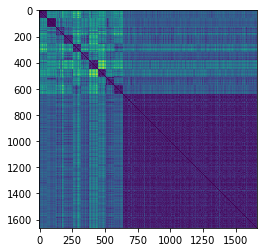

In [14]:
from tools.analyzer import Distance
import tools.analyzer as ana


idx = -1
stacked = np.vstack((semb_list[idx], uemb_list[idx][ulabel_list[idx].argsort()]))

similarity = ana.get_pairwise_distance(
  stacked, 
  Distance.l2)


dot_similarity = (stacked@stacked.T)

import matplotlib.pyplot as plt
fig = plt.figure()

#plt.imshow(dot_similarity)
plt.imshow(similarity)


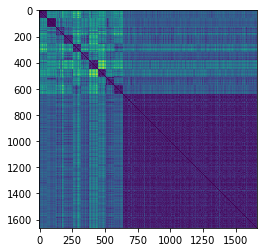

In [17]:
idx = -1
stacked = np.vstack((semb_list[idx], uemb_list[idx][ulabel_list[idx].argsort()]))

similarity = ana.get_pairwise_distance(
  stacked, 
  Distance.l2)


dot_similarity = (stacked@stacked.T)

import matplotlib.pyplot as plt
fig = plt.figure()

#plt.imshow(dot_similarity)
plt.imshow(similarity)